In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
workspace = 'D:/heat/data/'

# Calculate heat index

In [3]:
weather = pd.read_csv(workspace + '2024_72278023183.csv')
weather = weather[(weather['TMP'] != '+9999,9') & (weather['DEW'] != '+9999,9')]
weather = weather[['DATE', 'TMP', 'DEW']]

# Convert the 'date' column to datetime format
weather['DATE'] = pd.to_datetime(weather['DATE'])
"""
# Select June to September
start_date = '2024-06-01'
end_date = '2024-09-30'
weather = weather[(weather['DATE'] >= start_date) & (weather['DATE'] <= end_date)]
"""
start_date = '2024-05-27'
end_date = '2024-10-05'
weather = weather[(weather['DATE'] >= start_date) & (weather['DATE'] <= end_date)]

weather

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24908\1505279767.py:1: DtypeWarning: Columns (18,34,35,36,38,39,41,42,44,45,46,48,49,50,78) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv(workspace + '2024_72278023183.csv')


,DATE,TMP,DEW
4938,2024-05-27 00:00:00,"+0350,1","+0006,1"
4939,2024-05-27 00:51:00,"+0356,5","+0006,5"
4940,2024-05-27 01:49:00,"+0350,5","+0000,5"
4941,2024-05-27 01:51:00,"+0350,5","+0000,5"
4942,2024-05-27 02:51:00,"+0339,5","-0006,5"
...,...,...,...
9406,2024-10-04 21:00:00,"+0400,1","+0000,1"
9407,2024-10-04 21:51:00,"+0417,5","-0017,5"
9408,2024-10-04 22:51:00,"+0422,5","-0033,5"
9409,2024-10-04 23:51:00,"+0422,5","-0050,5"


In [4]:
# Extract temperature and dew point in Celsius from NOAA ISD format
def parse_temp(value):
    """Extract °C from NOAA ISD format"""
    raw = value.split(',')[0]
    return float(raw) / 10

weather['temp_c'] = weather['TMP'].apply(parse_temp)
weather['dew_c'] = weather['DEW'].apply(parse_temp)

# Convert Celsius to Fahrenheit
weather['temp_f'] = weather['temp_c'] * 9/5 + 32
weather['dew_f'] = weather['dew_c'] * 9/5 + 32

weather

,DATE,TMP,DEW,temp_c,dew_c,temp_f,dew_f
4938,2024-05-27 00:00:00,"+0350,1","+0006,1",35.0,0.6,95.00,33.08
4939,2024-05-27 00:51:00,"+0356,5","+0006,5",35.6,0.6,96.08,33.08
4940,2024-05-27 01:49:00,"+0350,5","+0000,5",35.0,0.0,95.00,32.00
4941,2024-05-27 01:51:00,"+0350,5","+0000,5",35.0,0.0,95.00,32.00
4942,2024-05-27 02:51:00,"+0339,5","-0006,5",33.9,-0.6,93.02,30.92
...,...,...,...,...,...,...,...
9406,2024-10-04 21:00:00,"+0400,1","+0000,1",40.0,0.0,104.00,32.00
9407,2024-10-04 21:51:00,"+0417,5","-0017,5",41.7,-1.7,107.06,28.94
9408,2024-10-04 22:51:00,"+0422,5","-0033,5",42.2,-3.3,107.96,26.06
9409,2024-10-04 23:51:00,"+0422,5","-0050,5",42.2,-5.0,107.96,23.00


In [5]:
# Compute Relative Humidity (RH) from temperature and dew point in °C
def compute_rh(temp_c, dew_c):
    es = 6.11 * 10 ** ((7.5 * temp_c) / (237.3 + temp_c))  # Saturation vapor pressure
    e = 6.11 * 10 ** ((7.5 * dew_c) / (237.3 + dew_c))     # Actual vapor pressure
    rh = 100 * e / es
    return np.clip(rh, 0, 100)

weather['rh'] = weather.apply(lambda row: compute_rh(row['temp_c'], row['dew_c']), axis=1)

# Compute Heat Index (HI) from temperature (°F) and RH (%)
def compute_heat_index(temp_f, rh):
    c1 = -42.379
    c2 = 2.04901523
    c3 = 10.14333127
    c4 = -0.22475541
    c5 = -0.00683783
    c6 = -0.05481717
    c7 = 0.00122874
    c8 = 0.00085282
    c9 = -0.00000199

    hi = (c1 + c2 * temp_f + c3 * rh + c4 * temp_f * rh + c5 * temp_f ** 2 +
          c6 * rh ** 2 + c7 * temp_f ** 2 * rh + c8 * temp_f * rh ** 2 +
          c9 * temp_f ** 2 * rh ** 2)
    return hi

weather['heat_index'] = weather.apply(lambda row: compute_heat_index(row['temp_f'], row['rh']), axis=1)
weather

,DATE,TMP,DEW,temp_c,dew_c,temp_f,dew_f,rh,heat_index
4938,2024-05-27 00:00:00,"+0350,1","+0006,1",35.0,0.6,95.00,33.08,11.347632,90.276229
4939,2024-05-27 00:51:00,"+0356,5","+0006,5",35.6,0.6,96.08,33.08,10.978301,91.234545
4940,2024-05-27 01:49:00,"+0350,5","+0000,5",35.0,0.0,95.00,32.00,10.863999,90.245280
4941,2024-05-27 01:51:00,"+0350,5","+0000,5",35.0,0.0,95.00,32.00,10.863999,90.245280
4942,2024-05-27 02:51:00,"+0339,5","-0006,5",33.9,-0.6,93.02,30.92,11.053214,88.492403
...,...,...,...,...,...,...,...,...,...
9406,2024-10-04 21:00:00,"+0400,1","+0000,1",40.0,0.0,104.00,32.00,8.282076,98.095047
9407,2024-10-04 21:51:00,"+0417,5","-0017,5",41.7,-1.7,107.06,28.94,6.682133,100.325273
9408,2024-10-04 22:51:00,"+0422,5","-0033,5",42.2,-3.3,107.96,26.06,5.778984,100.761472
9409,2024-10-04 23:51:00,"+0422,5","-0050,5",42.2,-5.0,107.96,23.00,5.083836,100.516177


In [6]:
# Extract the row with the highest heat_index for each date
max_hi_per_day = weather.loc[weather.groupby(weather['DATE'].dt.date)['heat_index'].idxmax()]
max_hi_per_day.to_csv("2024_max_hi_per_day.csv", index=False)
max_hi_per_day

,DATE,TMP,DEW,temp_c,dew_c,temp_f,dew_f,rh,heat_index
4971,2024-05-27 22:51:00,"+0383,5","-0017,5",38.3,-1.7,100.94,28.94,8.009611,95.291675
5004,2024-05-28 21:51:00,"+0400,5","-0044,5",40.0,-4.4,104.00,24.08,5.976508,97.553362
5007,2024-05-29 00:00:00,"+0394,1","-0061,1",39.4,-6.1,102.92,21.02,5.422203,96.571120
5068,2024-05-30 20:51:00,"+0400,5","-0044,5",40.0,-4.4,104.00,24.08,5.976508,97.553362
5103,2024-05-31 21:51:00,"+0406,5","-0050,5",40.6,-5.0,105.08,23.00,5.531628,98.339364
...,...,...,...,...,...,...,...,...,...
9306,2024-10-01 21:51:00,"+0450,5","+0006,5",45.0,0.6,113.00,33.08,6.658537,105.464571
9309,2024-10-02 00:00:00,"+0433,2","-0006,2",43.3,-0.6,109.94,30.92,6.662653,102.803760
9374,2024-10-03 22:51:00,"+0422,5","-0050,5",42.2,-5.0,107.96,23.00,5.083836,100.516177
9408,2024-10-04 22:51:00,"+0422,5","-0033,5",42.2,-3.3,107.96,26.06,5.778984,100.761472


min     90.24528
max    113.87594
Name: heat_index, dtype: float64

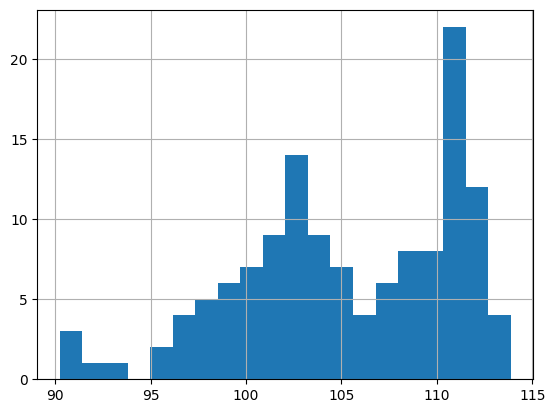

In [7]:
max_hi_per_day['heat_index'].hist(bins=20)
max_hi_per_day['heat_index'].agg(['min', 'max'])

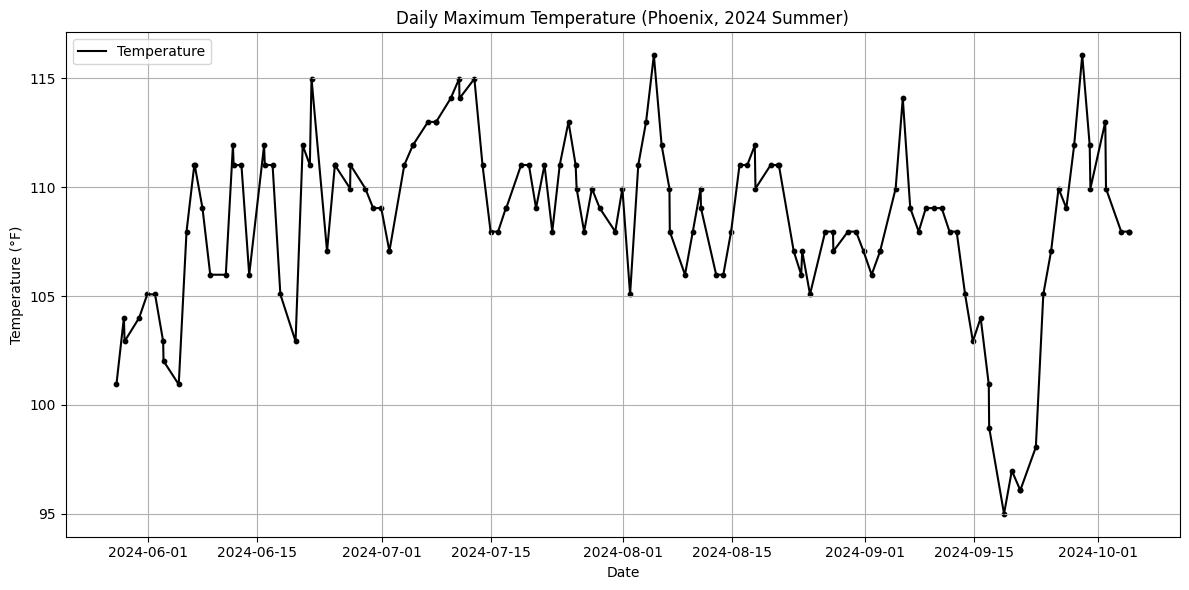

In [8]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(max_hi_per_day['DATE'], max_hi_per_day['temp_f'], label='Temperature', color='black')

# Point
plt.scatter(max_hi_per_day['DATE'], max_hi_per_day['temp_f'], color='black', s=10)

# X axis label
plt.xticks(rotation=0)

# Formatting
plt.title("Daily Maximum Temperature (Phoenix, 2024 Summer)")
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=0)

# Save the figure
plt.savefig("2024_temp.png", dpi=300, bbox_inches='tight')

plt.show()

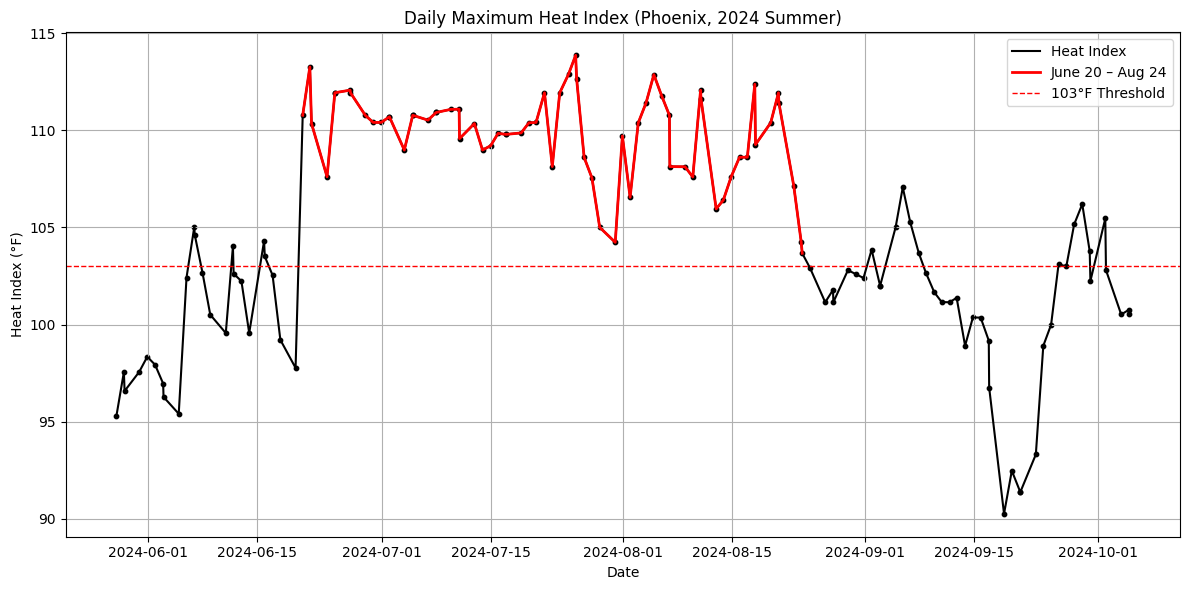

In [9]:
# Define red line period
start_red = pd.to_datetime("2024-06-20")
end_red = pd.to_datetime("2024-08-24")

# Create a mask for the red-highlighted period
red_period = (max_hi_per_day['DATE'] >= start_red) & (max_hi_per_day['DATE'] <= end_red)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(max_hi_per_day['DATE'], max_hi_per_day['heat_index'], label='Heat Index', color='black')

# Red line only in specified date range
plt.plot(max_hi_per_day.loc[red_period, 'DATE'], max_hi_per_day.loc[red_period, 'heat_index'], color='red', linewidth=2, label='June 20 – Aug 24')

# Point
plt.scatter(max_hi_per_day['DATE'], max_hi_per_day['heat_index'], color='black', s=10)

# Reference line at 103°F
plt.axhline(103, color='red', linestyle='--', linewidth=1, label='103°F Threshold')

# X axis label
plt.xticks(rotation=0)

# Formatting
plt.title("Daily Maximum Heat Index (Phoenix, 2024 Summer)")
plt.xlabel("Date")
plt.ylabel("Heat Index (°F)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=0)

# Save the figure
plt.savefig("2024_heat.png", dpi=300, bbox_inches='tight')

plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24908\3887079003.py:1: DtypeWarning: Columns (35,36,37,42,45,48,49,81) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv(workspace + '2023_72278023183.csv')


<Axes: >

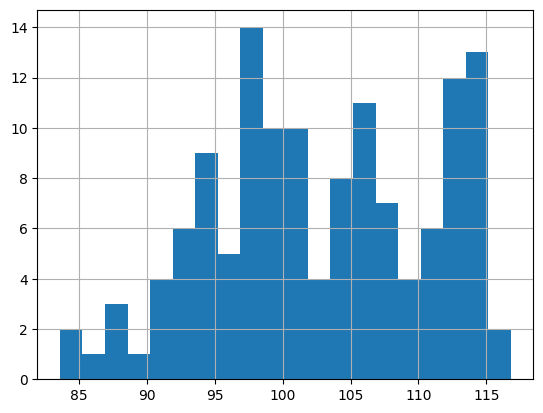

In [10]:
weather = pd.read_csv(workspace + '2023_72278023183.csv')
weather = weather[(weather['TMP'] != '+9999,9') & (weather['DEW'] != '+9999,9')]
weather = weather[['DATE', 'TMP', 'DEW']]

# Convert the 'date' column to datetime format
weather['DATE'] = pd.to_datetime(weather['DATE'])

# Select June to September
start_date = '2023-05-27'
end_date = '2023-10-05'
weather = weather[(weather['DATE'] >= start_date) & (weather['DATE'] <= end_date)]

# Extract temperature and dew point in Celsius from NOAA ISD format
weather['temp_c'] = weather['TMP'].apply(parse_temp)
weather['dew_c'] = weather['DEW'].apply(parse_temp)

# Convert Celsius to Fahrenheit
weather['temp_f'] = weather['temp_c'] * 9/5 + 32
weather['dew_f'] = weather['dew_c'] * 9/5 + 32

# Calculate RH and HI
weather['rh'] = weather.apply(lambda row: compute_rh(row['temp_c'], row['dew_c']), axis=1)
weather['heat_index'] = weather.apply(lambda row: compute_heat_index(row['temp_f'], row['rh']), axis=1)

# Extract the row with the highest heat_index for each date
max_hi_per_day = weather.loc[weather.groupby(weather['DATE'].dt.date)['heat_index'].idxmax()]
max_hi_per_day.to_csv("2023_max_hi_per_day.csv", index=False)

max_hi_per_day['heat_index'].hist(bins=20)

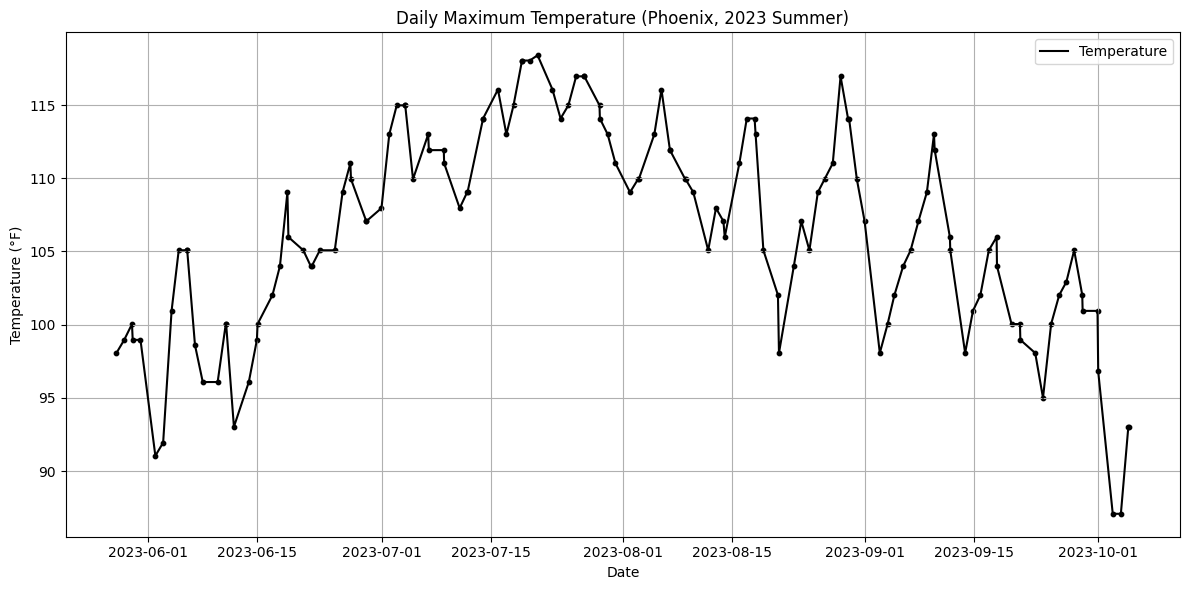

In [11]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(max_hi_per_day['DATE'], max_hi_per_day['temp_f'], label='Temperature', color='black')

# Point
plt.scatter(max_hi_per_day['DATE'], max_hi_per_day['temp_f'], color='black', s=10)

# Formatting
plt.title("Daily Maximum Temperature (Phoenix, 2023 Summer)")
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=0)

# Save the figure
plt.savefig("2023_temp.png", dpi=300, bbox_inches='tight')

plt.show()

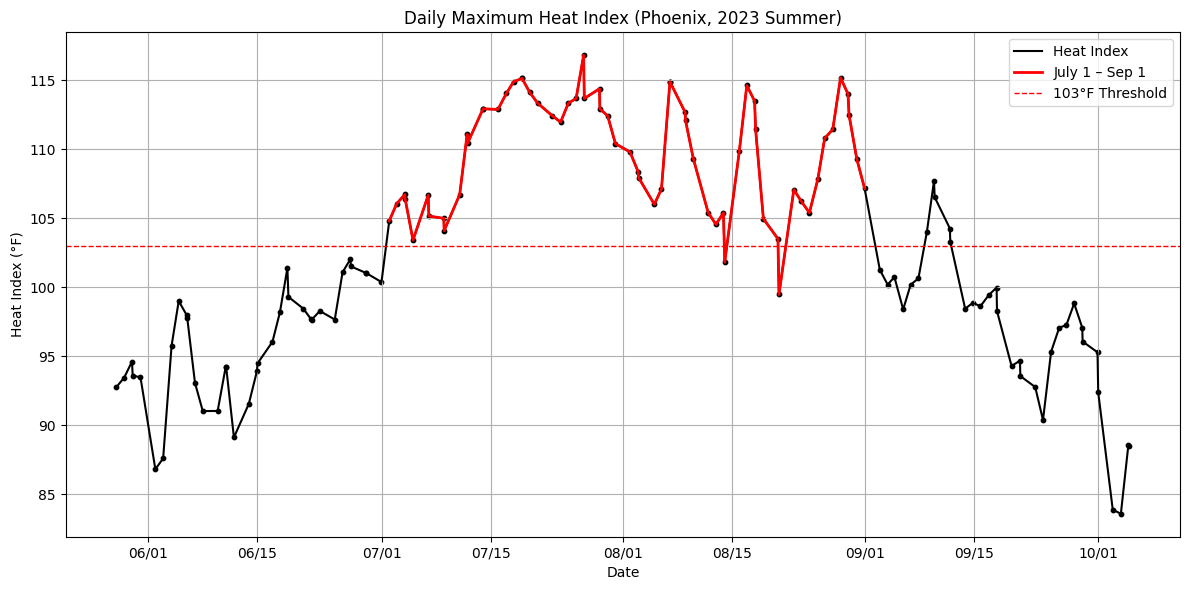

In [12]:
# Define red line period
start_red = pd.to_datetime("2023-07-01")
end_red = pd.to_datetime("2023-09-01")

# Create a mask for the red-highlighted period
red_period = (max_hi_per_day['DATE'] >= start_red) & (max_hi_per_day['DATE'] <= end_red)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(max_hi_per_day['DATE'], max_hi_per_day['heat_index'], label='Heat Index', color='black')

# Red line only in specified date range
plt.plot(max_hi_per_day.loc[red_period, 'DATE'], max_hi_per_day.loc[red_period, 'heat_index'], color='red', linewidth=2, label='July 1 – Sep 1')

# Point
plt.scatter(max_hi_per_day['DATE'], max_hi_per_day['heat_index'], color='black', s=10)

# Reference line at 103°F
plt.axhline(103, color='red', linestyle='--', linewidth=1, label='103°F Threshold')

# X axis label
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xticks(rotation=0)

# Formatting
plt.title("Daily Maximum Heat Index (Phoenix, 2023 Summer)")
plt.xlabel("Date")
plt.ylabel("Heat Index (°F)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=0)

# Save the figure
plt.savefig("2023_heat.png", dpi=300, bbox_inches='tight')

plt.show()